# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [1]:
import numpy as np
from numpy.linalg import det, inv
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)
 
    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)
    
    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [4]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    self.result = 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
    # print(f"Predict log condicitional of {class_idx}: ", self.result)
    return self.result
  

In [5]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        # print("X:", x)
        
        unbiased_x = x - self.tensor_means
        # print("Unbiased x: ", unbiased_x)
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
        
        result = 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()
        return result
        # return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [6]:
# hiperparámetros
rng_seed = 6543

In [7]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [607]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [608]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [8]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
    result = (y_true == y_pred)
    return result.mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [610]:
qda = QDA()

# La funcion fit se puede pasar un tercer parámetro que actuaria como 
qda.fit(train_x, train_y)

In [611]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [612]:
%%timeit

qda.predict(test_x)

5.91 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [613]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

7.48 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.>
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


## 1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.

### 1.1 Distribución apriori uniforme

In [9]:
# Variables globales
errors = {}

# Preparamos los dataset de evaluación y prueba
X_iris_full, y_iris_full = get_iris_dataset()
train_iris_x, train_iris_y, test_iris_x, test_iris_y = split_transpose(X_iris_full, y_iris_full, 0.4, rng_seed)

In [10]:
def train_evaluate_qda(x_full, y_full, a_priori=None, test_size=0.4, random_state=6543, error_name="", dataset="Iris"):
    train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, test_size, random_state)

    qda = QDA()
    qda.fit(train_x, train_y, a_priori)


    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    full_qda_iris_acc = accuracy(y_full.reshape(1,-1), qda.predict(x_full.T))
    print(f"Modelo QDA - Dataset {dataset} - Seeds {random_state} - Probabilities {a_priori}")
    print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f} and full error is {1-full_qda_iris_acc:.4f}")
    print()

    result = round(1-train_acc, 4), round(1-test_acc, 4)
    if error_name:
      errors[f"{error_name}_seeds-{random_state}"] = result

    return qda

In [11]:
# %%timeit
# Entrenamos el modelo
qda_uniforme = train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, a_priori=[1/3, 1/3, 1/3], error_name="qda_iris_[1/3, 1/3, 1/3]", dataset="Iris")

Modelo QDA - Dataset Iris - Seeds 6543 - Probabilities [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Train (apparent) error is 0.0222 while test error is 0.0167 and full error is 0.0200



In [12]:
train_acc = accuracy(train_iris_y, qda_uniforme.predict(train_iris_x))
test_acc = accuracy(test_iris_y, qda_uniforme.predict(test_iris_x))
full_acc = accuracy(y_iris_full.reshape(1,-1), qda_uniforme.predict(X_iris_full.T))
# print(train_acc*train_y.size)
# print(test_acc*test_y.size)
# print(full_acc*y_full.reshape(1,-1).size)
print(f"Train (apparent) error is {(1-train_acc):.4f} while test error is {1-test_acc:.4f} and full error is {1-full_acc:.4f}")

Train (apparent) error is 0.0222 while test error is 0.0167 and full error is 0.0200


### 2.2 Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

In [13]:
# Entrenamos el modelo
# Vamos a entrenar tres modelos cada uno de ellos tendrá el nombre de la especie más dominante en la distribución

qda_setosa = train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, a_priori=[0.90, 0.05, 0.05], error_name="qda_iris_[0.90, 0.05, 0.05]", dataset="Iris")

# print(f"Distribución a prioriri setosa {qda_setosa.log_a_priori}")

qda_versicolor = train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, a_priori=[0.90, 0.9, 0.05], error_name="qda_iris_[0.05, 0.9, 0.05]", dataset="Iris")

# print(f"Distribución a prioriri versicolor {qda_versicolor.log_a_priori}")

qda_virginica = train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, a_priori=[0.05, 0.05,0.09], error_name="qda_iris_[0.05, 0.05, 0.9]", dataset="Iris")


# print(f"Distribución a prioriri virginica {qda_virginica.log_a_priori}")

# print(f"Distribución a prioriri uniforme {qda_uniforme.log_a_priori}")

Modelo QDA - Dataset Iris - Seeds 6543 - Probabilities [0.9, 0.05, 0.05]
Train (apparent) error is 0.0222 while test error is 0.0167 and full error is 0.0200

Modelo QDA - Dataset Iris - Seeds 6543 - Probabilities [0.9, 0.9, 0.05]
Train (apparent) error is 0.0333 while test error is 0.0000 and full error is 0.0200

Modelo QDA - Dataset Iris - Seeds 6543 - Probabilities [0.05, 0.05, 0.09]
Train (apparent) error is 0.0111 while test error is 0.0167 and full error is 0.0133



In [55]:
# Previmanete saquemos la cantidad de ocurrencias de cada especie en los dataset de entrenamiento y prueba
distribution_train = np.bincount(qda_uniforme.encoder.transform(train_iris_y).flatten().astype(int)) / train_iris_y.size
distribution_test = np.bincount(qda_uniforme.encoder.transform(test_iris_y).flatten().astype(int)) / test_iris_y.size
print(f"Ocurrencias de cada especie en el set de entrenamientos {distribution_train}")
print(f"Ocurrencias de cada especie en el set de test {distribution_test}")
print("\n")


# Full dataset

setosa_train_acc = accuracy(train_iris_y, qda_setosa.predict(train_iris_x))
setosa_test_acc = accuracy(test_iris_y, qda_setosa.predict(test_iris_x))
setosa_full_acc = accuracy(y_iris_full.reshape(1,-1), qda_setosa.predict(X_iris_full.T))
print(f"Setosa Train (apparent) error is {1-setosa_train_acc:.4f} while test error is {1-setosa_test_acc:.4f} and full error {1-setosa_full_acc:.4f}")
# print(setosa_train_acc*train_iris_y.size)
# print(setosa_test_acc*test_iris_y.size)
# print(setosa_full_acc*y_full.reshape(1,-1).size)

versicolor_train_acc = accuracy(train_iris_y, qda_versicolor.predict(train_iris_x))
versicolor_test_acc = accuracy(test_iris_y, qda_versicolor.predict(test_iris_x))
versicolor_full_acc = accuracy(y_iris_full.reshape(1,-1), qda_versicolor.predict(X_iris_full.T))
print(f"Versicolor Train (apparent) error is {1-versicolor_train_acc:.4f} while test error is {1-versicolor_test_acc:.4f} and full error {1-versicolor_full_acc:.4f}")
# print(versicolor_train_acc*train_iris_y.size)
# print(versicolor_test_acc*test_iris_y.size)
# print(versicolor_full_acc*y_iris_full.reshape(1,-1).size)

virginica_train_acc = accuracy(train_iris_y, qda_virginica.predict(train_iris_x))
virginica_test_acc = accuracy(test_iris_y, qda_virginica.predict(test_iris_x))
virginica_full_acc = accuracy(y_iris_full.reshape(1,-1), qda_virginica.predict(X_iris_full.T))
print(f"Virginica Train (apparent) error is {1-virginica_train_acc:.4f} while test error is {1-virginica_test_acc:.4f} and full error {1-virginica_full_acc:.4f}")
# print(virginica_train_acc*train_iris_y.size)
# print(virginica_test_acc*test_iris_y.size)
# print(virginica_full_acc*y_iris_full.reshape(1,-1).size)

Ocurrencias de cada especie en el set de entrenamientos [0.3        0.32222222 0.37777778]
Ocurrencias de cada especie en el set de test [0.38333333 0.35       0.26666667]


Setosa Train (apparent) error is 0.0222 while test error is 0.0167 and full error 0.0200
Versicolor Train (apparent) error is 0.0333 while test error is 0.0000 and full error 0.0200
Virginica Train (apparent) error is 0.0111 while test error is 0.0167 and full error 0.0133


**De los resultados obtenidos, no se observan diferencias significativas al entrenar el modelo con las diferentes distribuciones (uniforme y las 3 distribuciones desbalancedas). A nuestro entender, esto se debe a que existe una clara separación entre clases, es decir que las características de las tres especies de plantas difieren marcadamente entre sí. Esta situación genera que la influencia que genera $\pi_j$ sea mínima.**

**Además, hay que destacar que QDA modela cada clase con su propia matriz de covarianza, de esta forma el modelo captura de manera más específica la distribución de cada clase.**

**A continuación se realiza un gráfico de dispersión para observar la separación de clases.** 

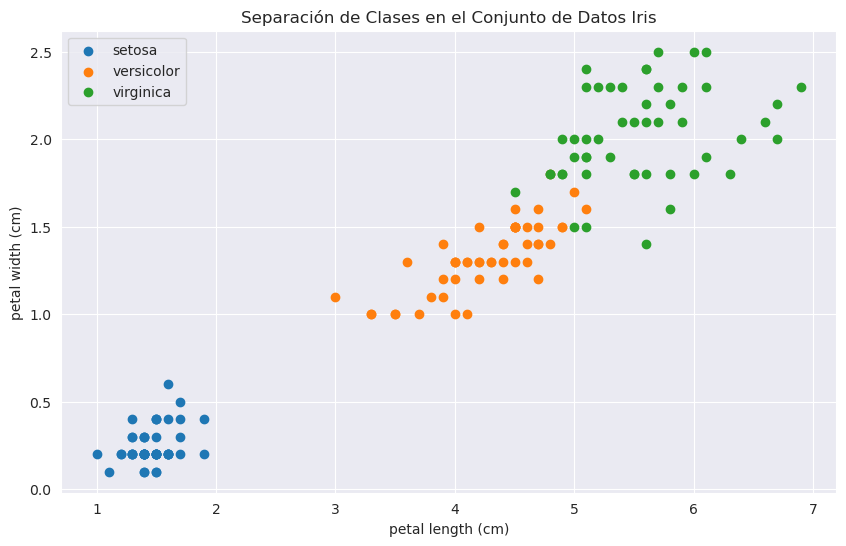

In [15]:
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Mapear los valores numéricos a nombres de clases
df['target'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Visualización de la separación entre clases usando las dos características más separables
plt.figure(figsize=(10, 6))
for class_name in data.target_names:
    subset = df[df['target'] == class_name]
    plt.scatter(subset[data.feature_names[2]], subset[data.feature_names[3]], label=class_name)
plt.xlabel(data.feature_names[2])
plt.ylabel(data.feature_names[3])
plt.legend()
plt.title('Separación de Clases en el Conjunto de Datos Iris')
plt.show()

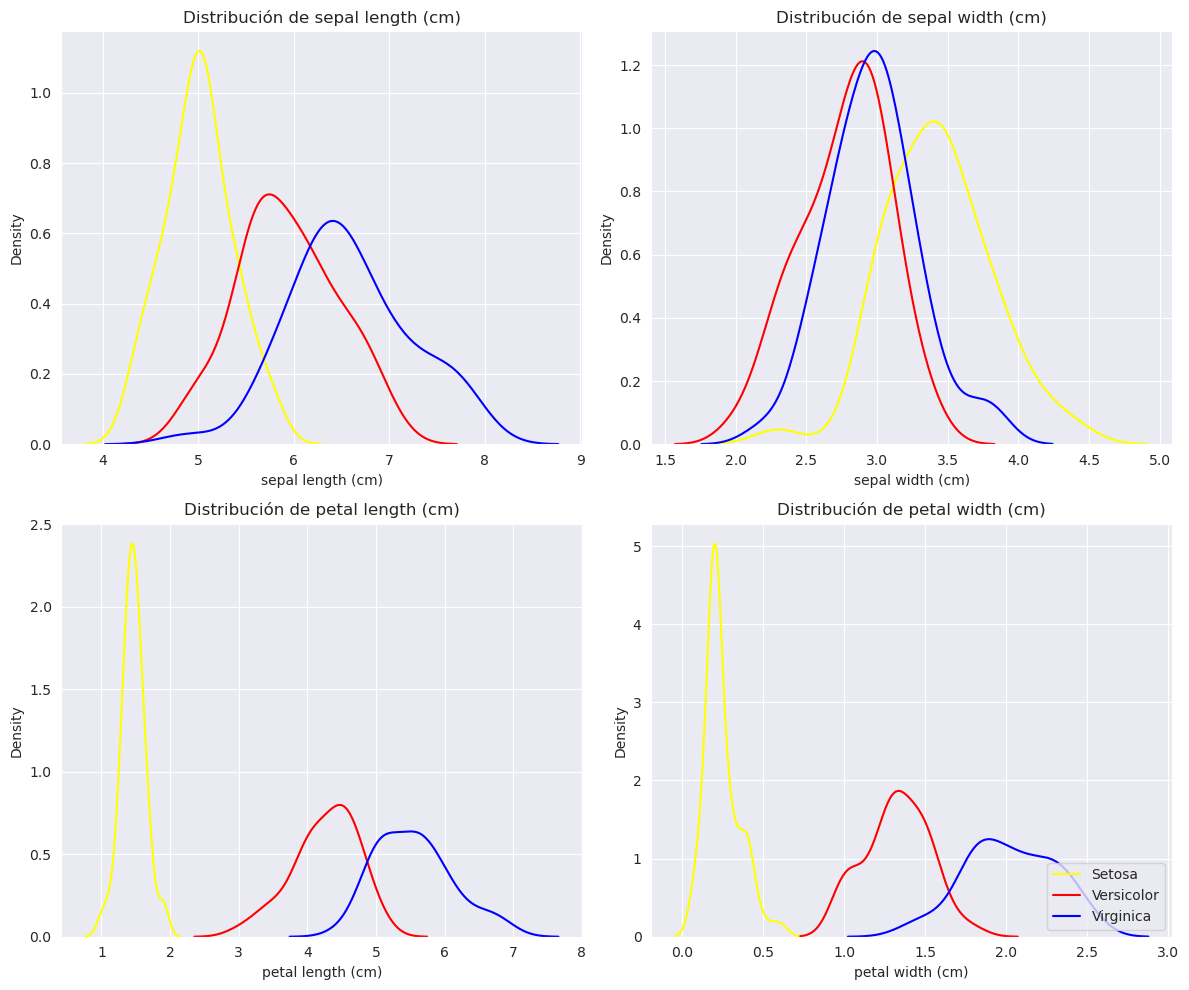

In [16]:
features_name = df.drop(columns=['target']).columns

df_iris_setosa = df[df['target'] == 'setosa']
df_iris_versicolor = df[df['target'] =='versicolor']
df_iris_virginica = df[df['target'] == 'virginica']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(features_name):
    sns.kdeplot(df_iris_setosa[col], ax=axes[i//2, i%2], color='yellow', legend=True, label='Setosa')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    sns.kdeplot(df_iris_versicolor[col], ax=axes[i//2, i%2], color='red', label='Versicolor')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    sns.kdeplot(df_iris_virginica[col], ax=axes[i//2, i%2], color='blue', label='Virginica')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 2. Repetir el punto anterior para el dataset *penguin*.

### 1.1 Distribución apriori uniforme


In [107]:
# Preparamos los dataset de evaluación y prueba
X_penguins_full, y_penguins_full = get_penguins()
train_penguins_x, train_penguins_y, test_penguins_x, test_penguins_y = split_transpose(X_penguins_full, y_penguins_full, 0.4, rng_seed)
df_X_penguins_full = pd.DataFrame(X_penguins_full)
df_y_penguins_full = pd.DataFrame(y_penguins_full)
df_train_penguins_x = pd.DataFrame(train_penguins_x)
df_train_penguins_y = pd.DataFrame(train_penguins_y)
df_test_penguins_x = pd.DataFrame(test_penguins_x)
df_test_penguins_y = pd.DataFrame(test_penguins_y)

print("Full peunguin datatset:\n", df_y_penguins_full.value_counts())
print("Test peunguin datatset:\n", df_test_penguins_y.T.value_counts())
print("Train peunguin datatset:\n", df_train_penguins_y.T.value_counts())

Full peunguin datatset:
 Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64
Test peunguin datatset:
 Adelie       67
Gentoo       41
Chinstrap    29
Name: count, dtype: int64
Train peunguin datatset:
 Adelie       84
Gentoo       82
Chinstrap    39
Name: count, dtype: int64


In [92]:
qda_penguins = QDA()
qda_penguins.fit(train_penguins_x, train_penguins_y)
print("Probabilidad a priori según la muestra:", np.exp(qda_penguins.log_a_priori))
print("Ocurrencia de cada especie (adelie, chinstrap, gentoo):", train_penguins_y.size*np.exp(qda_penguins.log_a_priori))
train_acc = accuracy(train_penguins_y, qda_penguins.predict(train_penguins_x))
test_acc = accuracy(test_penguins_y, qda_penguins.predict(test_penguins_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")


Probabilidad a priori según la muestra: [0.4097561 0.1902439 0.4      ]
Ocurrencia de cada especie (adelie, chinstrap, gentoo): [84. 39. 82.]
Train (apparent) error is 0.0146 while test error is 0.0146


In [65]:
qda_penguin_uniforme = train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, a_priori=np.array([1/3, 1/3, 1/3]), error_name="qda_penguins_[1/3, 1/3, 1/3]", dataset="Penguins")

Modelo QDA - Dataset Penguins - Seeds 6543 - Probabilities [0.33333333 0.33333333 0.33333333]
Train (apparent) error is 0.0098 while test error is 0.0073 and full error is 0.0088



### 2.2 Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

In [66]:
# Entrenamos el modelo
# Vamos a entrenar tres modelos cada uno de ellos tendrá el nombre de la especie más dominante en la distribución

a_priori_adelie = np.array([0.9, 0.05,0.05])
qda_adelie = train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, a_priori=a_priori_adelie, error_name="qda_penguins_[0.9, 0.05, 0.05]", dataset="Penguins")
a_priori_chinstrap = np.array([0.05, 0.9,0.05])
qda_chinstrap = train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, a_priori=a_priori_chinstrap, error_name="qda_penguins_[0.05, 0.9, 0.05]", dataset="Penguins")

a_priori_gentoo = np.array([0.05, 0.05, 0.9])
qda_gentoo = train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, a_priori=a_priori_gentoo, error_name="qda_penguins_[0.05, 0.05, 0.9]", dataset="Penguins")


Modelo QDA - Dataset Penguins - Seeds 6543 - Probabilities [0.9  0.05 0.05]
Train (apparent) error is 0.0195 while test error is 0.0219 and full error is 0.0205

Modelo QDA - Dataset Penguins - Seeds 6543 - Probabilities [0.05 0.9  0.05]
Train (apparent) error is 0.0098 while test error is 0.0219 and full error is 0.0146

Modelo QDA - Dataset Penguins - Seeds 6543 - Probabilities [0.05 0.05 0.9 ]
Train (apparent) error is 0.0098 while test error is 0.0073 and full error is 0.0088



In [108]:
df_penguins, target_penguins = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')
df_penguins.drop(columns=['island', 'sex'], inplace=True)
mask = df_penguins.isna().sum(axis=1) == 0#.sum(axis=1) == 0
df_penguins = df_penguins[mask]
mapping_dic = {'Adelie':0, 'Chinstrap': 1, 'Gentoo':2}
reverse_mapping = ['Adelie', 'Chinstrap', 'Gentoo']
target_penguins = np.array(target_penguins[mask].map(mapping_dic))
proba = np.bincount(target_penguins).astype(int)/len(target_penguins)

print(proba)
fer= np.bincount(target_penguins)
# df_penguins = pd.DataFrame(data_penguins.data, columns=data_penguins.feature_names)
df_penguins['target'] = np.array(target_penguins)



[0.44152047 0.19883041 0.35964912]


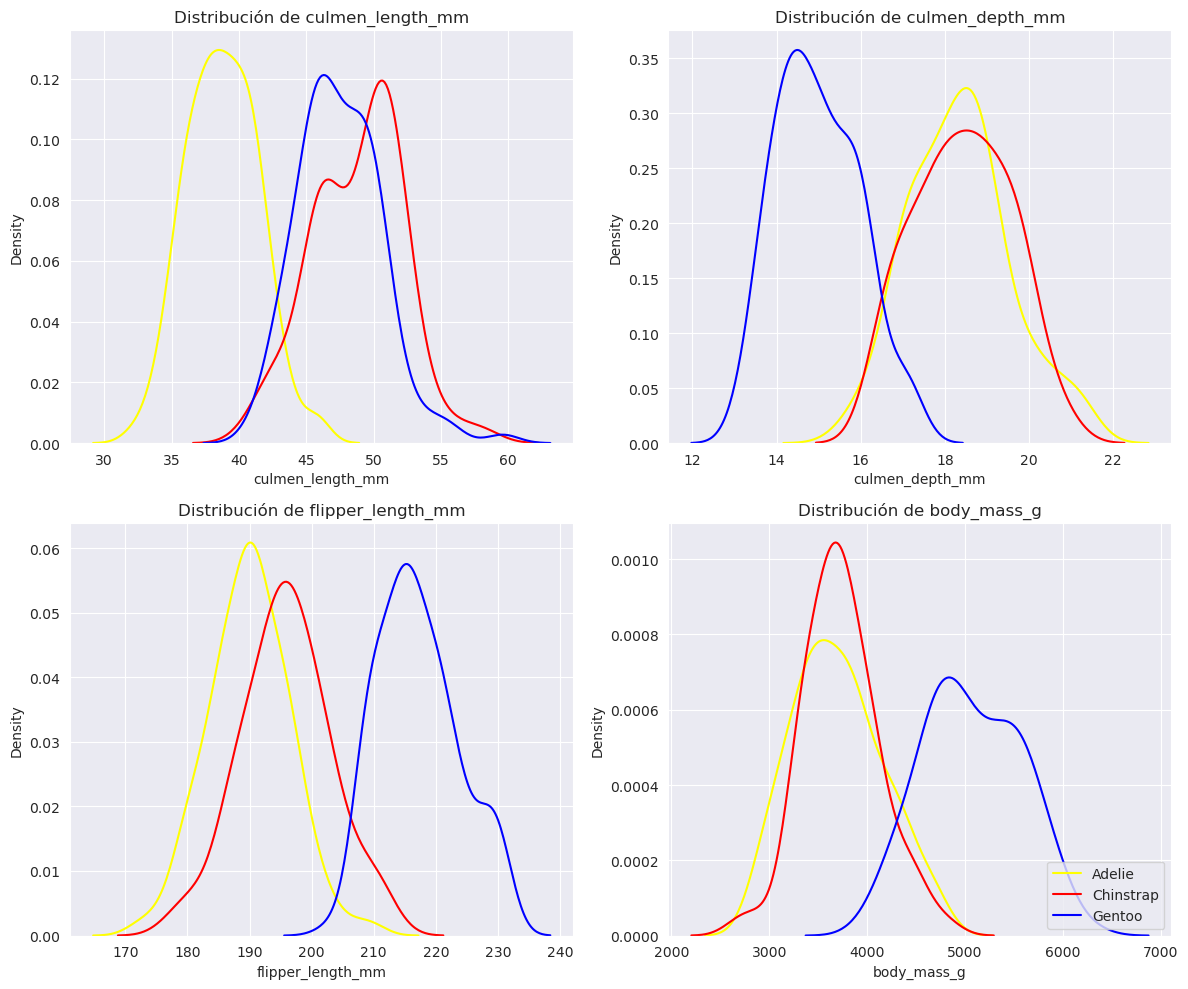

In [109]:
features_name = df_penguins.drop(columns=['target']).columns

df_penguins_adeline = df_penguins[df_penguins['target'] == 0]
df_penguins_chinstrap = df_penguins[df_penguins['target'] == 1]
df_penguins_gentoo = df_penguins[df_penguins['target'] == 2]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(features_name):
    sns.kdeplot(df_penguins_adeline[col], ax=axes[i//2, i%2], color='yellow', legend=True, label='Adelie')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    sns.kdeplot(df_penguins_chinstrap[col], ax=axes[i//2, i%2], color='red', label='Chinstrap')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    sns.kdeplot(df_penguins_gentoo[col], ax=axes[i//2, i%2], color='blue', label='Gentoo')
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

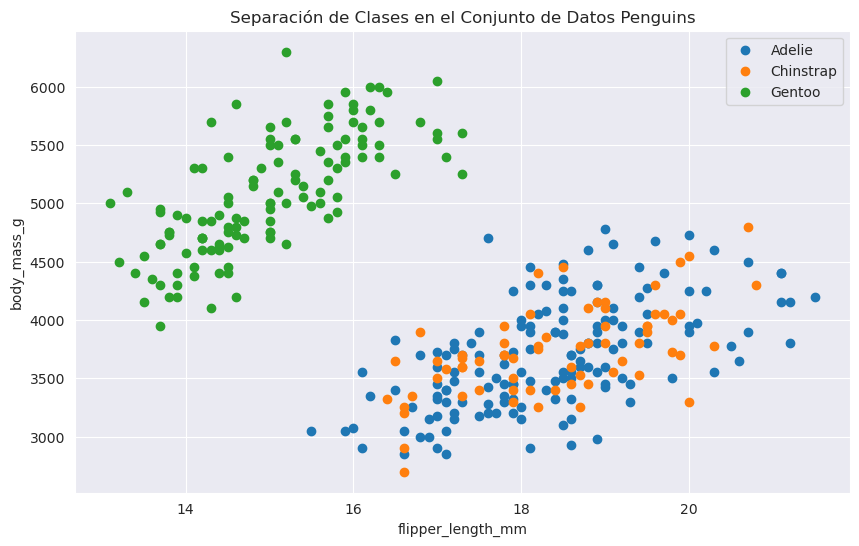

In [23]:
# Mapear los valores numéricos a nombres de clases
columns_names = list(df_penguins.columns)

# Visualización de la separación entre clases usando las dos características más separables
plt.figure(figsize=(10, 6))
for class_name in mapping_dic.values():
    subset = df_penguins[df_penguins['target'] == class_name]
    plt.scatter(subset[columns_names[1]], subset[columns_names[3]], label=reverse_mapping[class_name])
plt.xlabel(columns_names[2])
plt.ylabel(columns_names[3])
plt.legend()
plt.title('Separación de Clases en el Conjunto de Datos Penguins')
plt.show()

Escribir conclusiones

## 3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

#### Implementación del modelo LDA

In [110]:
class LDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate one covariance matrix
    self.inv_cov = inv(np.cov(X, bias=True))
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=ceass_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    unbiased_x =  x - self.means[class_idx]
    # return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
    self.result = 0.5*np.log(det(self.inv_cov)) -0.5 * unbiased_x.T @ self.inv_cov @ unbiased_x
    # print(f"Predict log condicitional of {class_idx}: ", self.result)
    return self.result

In [111]:
def train_evaluate_lda(x_full, y_full, test_size=0.4, random_state=6543, error_name="", dataset="Iris"):
    train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, test_size, random_state)

    # Creamos una instancia
    lda = LDA()

    # Entrenar y evaluar el modelo LDA
    lda.fit(train_x, train_y)

    # Evaluamos el modelo en los conjuntos de entrenamiento y prueba
    train_acc = accuracy(train_y, lda.predict(train_x))
    test_acc = accuracy(test_y, lda.predict(test_x))
    full_qda_iris_acc = accuracy(y_full.reshape(1,-1), lda.predict(x_full.T))
    print(f"Modelo LDA - Dataset {dataset} - Seeds {random_state}")
    print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f} and full error is {1-full_qda_iris_acc:.4f}")
    print()

    result = round(1-train_acc, 4), round(1-test_acc, 4)
    if error_name:
      errors[f"{error_name}_seeds-{random_state}"] = result
    
    return lda


### IRIS DATASET


##### LDA

In [112]:
lda_iris = train_evaluate_lda(x_full=X_iris_full, y_full=y_iris_full, error_name="lda_iris", dataset="Iris")

print(f"Distribución a prioriri {np.exp(lda_iris.log_a_priori)}")

Modelo LDA - Dataset Iris - Seeds 6543
Train (apparent) error is 0.1222 while test error is 0.2000 and full error is 0.1533

Distribución a prioriri [0.3        0.32222222 0.37777778]


##### QDA

In [128]:
# %%timeit
# Entrenamos el modelo
qda_iris = train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, error_name="qda_iris", dataset="Iris")
print("Matriz de covarianza: ")
print(inv(qda_iris.inv_covs))

Modelo QDA - Dataset Iris - Seeds 6543 - Probabilities None
Train (apparent) error is 0.0111 while test error is 0.0167 and full error is 0.0133

Matriz de covarianza: 
[[[0.11333333 0.09469136 0.00666667 0.00864198]
  [0.09469136 0.13262003 0.00522634 0.01207133]
  [0.00666667 0.00522634 0.01876543 0.00218107]
  [0.00864198 0.01207133 0.00218107 0.01064472]]

 [[0.28725327 0.10743163 0.20587396 0.07186683]
  [0.10743163 0.10097503 0.09294887 0.042283  ]
  [0.20587396 0.09294887 0.23690844 0.08634958]
  [0.07186683 0.042283   0.08634958 0.03964328]]

 [[0.35831315 0.11100346 0.2350692  0.04198962]
  [0.11100346 0.10515571 0.0766436  0.05982699]
  [0.2350692  0.0766436  0.22816609 0.03977509]
  [0.04198962 0.05982699 0.03977509 0.08875433]]]


### PENGUINS DATASET

##### LDA

In [114]:
lda_penguin = train_evaluate_lda(x_full=X_penguins_full, y_full=y_penguins_full, error_name="lda_penguins", dataset="Penguins")
print(f"Distribución a prioriri {np.exp(lda_penguin.log_a_priori)}")

Modelo LDA - Dataset Penguins - Seeds 6543
Train (apparent) error is 0.0195 while test error is 0.0219 and full error is 0.0205

Distribución a prioriri [0.4097561 0.1902439 0.4      ]


##### QDA

In [118]:
qda_penguin = train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, error_name="qda_penguins", dataset="Penguins")
print(f"Distribución a priori {np.exp(lda_penguin.log_a_priori)}")
print("Matriz de covarianza: ")
print(inv(qda_penguin.inv_covs))

Modelo QDA - Dataset Penguins - Seeds 6543 - Probabilities None
Train (apparent) error is 0.0146 while test error is 0.0146 and full error is 0.0146

Distribución a priori [0.4097561 0.1902439 0.4      ]
Matriz de covarianza: 
[[[7.47747732e+00 1.24578231e+00 7.18276644e+00 7.74933390e+02]
  [1.24578231e+00 1.51098639e+00 2.85289116e+00 3.61181973e+02]
  [7.18276644e+00 2.85289116e+00 4.73667800e+01 1.51128118e+03]
  [7.74933390e+02 3.61181973e+02 1.51128118e+03 2.23303217e+05]]

 [[8.48194609e+00 2.18258383e+00 1.16796187e+01 4.33768902e+02]
  [2.18258383e+00 1.20844181e+00 4.81183432e+00 2.02726824e+02]
  [1.16796187e+01 4.81183432e+00 5.00959895e+01 1.49488823e+03]
  [4.33768902e+02 2.02726824e+02 1.49488823e+03 1.35607331e+05]]

 [[9.21329120e+00 2.17397234e+00 1.27177127e+01 9.37583284e+02]
  [2.17397234e+00 1.12415378e+00 4.83091910e+00 3.83097858e+02]
  [1.27177127e+01 4.83091910e+00 4.27128198e+01 2.18095628e+03]
  [9.37583284e+02 3.83097858e+02 2.18095628e+03 2.24970256e+05]]]

## 4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

### IRIS DATASET

In [127]:
# Con array de seeds
seeds_array = [5398, 2365]

# QDA
for seed in seeds_array:
    train_evaluate_qda(x_full=X_iris_full, y_full=y_iris_full, random_state=seed, error_name=f"qda_iris", dataset="Iris")
    train_evaluate_qda(x_full=X_penguins_full, y_full=y_penguins_full, random_state=seed, error_name=f"qda_penguins", dataset="Penguins")

# LDA
for seed in seeds_array:
    train_evaluate_lda(x_full=X_iris_full, y_full=y_iris_full, random_state=seed, error_name=f"lda_iris", dataset="Iris")
    train_evaluate_lda(x_full=X_penguins_full, y_full=y_penguins_full, random_state=seed, error_name=f"lda_penguins", dataset="Penguins")


Modelo QDA - Dataset Iris - Seeds 5398 - Probabilities None
Train (apparent) error is 0.0111 while test error is 0.0333 and full error is 0.0200

Modelo QDA - Dataset Penguins - Seeds 5398 - Probabilities None
Train (apparent) error is 0.0098 while test error is 0.0219 and full error is 0.0146

Modelo QDA - Dataset Iris - Seeds 2365 - Probabilities None
Train (apparent) error is 0.0222 while test error is 0.0000 and full error is 0.0133

Modelo QDA - Dataset Penguins - Seeds 2365 - Probabilities None
Train (apparent) error is 0.0098 while test error is 0.0146 and full error is 0.0117

Modelo LDA - Dataset Iris - Seeds 5398
Train (apparent) error is 0.1000 while test error is 0.2167 and full error is 0.1467

Modelo LDA - Dataset Penguins - Seeds 5398
Train (apparent) error is 0.0146 while test error is 0.0292 and full error is 0.0205

Modelo LDA - Dataset Iris - Seeds 2365
Train (apparent) error is 0.1444 while test error is 0.1667 and full error is 0.1533

Modelo LDA - Dataset Penguins

In [43]:
# Mostrar errores
for error_name, error_values in errors.items():
    print(f"{error_name:<45} | Train error: {error_values[0]:<6} | Test error: {error_values[1]}")

qda_iris_[1/3, 1/3, 1/3]_seeds-6543           | Train error: 0.0222 | Test error: 0.0167
qda_iris_[0.90, 0.05, 0.05]_seeds-6543        | Train error: 0.0222 | Test error: 0.0167
qda_iris_[0.05, 0.9, 0.05]_seeds-6543         | Train error: 0.0333 | Test error: 0.0
qda_iris_[0.05, 0.05, 0.9]_seeds-6543         | Train error: 0.0111 | Test error: 0.0167
qda_penguins_[1/3, 1/3, 1/3]_seeds-6543       | Train error: 0.0098 | Test error: 0.0073
qda_penguins_[0.9, 0.05, 0.05]_seeds-6543     | Train error: 0.0195 | Test error: 0.0219
qda_penguins_[0.05, 0.9, 0.05]_seeds-6543     | Train error: 0.0098 | Test error: 0.0219
qda_penguins_[0.05, 0.05, 0.9]_seeds-6543     | Train error: 0.0098 | Test error: 0.0073
lda_iris_seeds-6543                           | Train error: 0.1222 | Test error: 0.2
qda_iris_seeds-6543                           | Train error: 0.0111 | Test error: 0.0167
lda_penguins_seeds-6543                       | Train error: 0.0195 | Test error: 0.0219
qda_penguins_seeds-6543    

CONCLUSION

## 5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?

###### QDA SIN TENSOR

In [647]:
qda_array = QDA()
qda_array.fit(train_iris_x, train_iris_y)

In [648]:
%%timeit
predict_qda_array_y = qda_array.predict(test_iris_x)

5.4 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


###### QDA CON TENSOR

In [649]:
qda_tensor = TensorizedQDA()
qda_tensor.fit(train_iris_x, train_iris_y)

In [650]:
import tracemalloc

# Para medir memoria consumida (usamos el pico de memoria)
tracemalloc.start()
predict_qda_tensor_y = qda_tensor.predict(test_iris_x)
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Maxima memoria ocupada: {round(memory_peak, 2)} [MB]", )

Maxima memoria ocupada: 0.01 [MB]


<p>Se observa una disminución considerable en el tiempo de predicción, de 4.41 ms a 1.63 ms.</p> <p>Esto se debe a que en TensorizedQDA no es necesario declarar iteraciones explícitas como en el caso de el método predict_one en la clase QDA, sino que las operaciones son realizadas mediante operaciones vectorizadas las cuales se encuentra programas en C dentro de la libreria numpy.<p>
Linea de código método _predict_one en la clase QDA en la cual se declara un bucle explicito para calcular las distintas probabilidades a posteriori:
<ul><li> (log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i in enumerate(self.log_a_priori) ])</li></ul>

Linea de código método _predict_one en la clase TensorizedQDA. En este caso la operación de cálculo probabilidad a posteriori se realiza de manera vectorizada dento de la librería, con lo cual aprovecha todas las optimizaciones de bajo nivel implementadas en C:
<ul><li> return np.argmax(self.log_a_priori + self._predict_log_conditionals(x)) </li></ul>

En conclusión, siempre es conveniente para el caso de operaciones iterativas, de ser posibles, realizarlas dentro de la libreria de modo de evitar la sobrecarga que produce python.

## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## 1.Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.

In [44]:

class FasterQDA(TensorizedQDA):

    def predict(self, x):
        tensor_unbiased_x = x - self.tensor_means
        inner_prod = tensor_unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ tensor_unbiased_x #--> ACA SE GENERA LA MATRIZ nXn
        result = np.argmax(self.log_a_priori + 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.diagonal(axis1=1, axis2=2).T, axis=1)
        y_hat = self.encoder.names[result]
        return y_hat.reshape(1,-1)

qda_faster = FasterQDA()
qda_faster.fit(train_iris_x, train_iris_y)



Tiempo de predicción FasterQDA

In [45]:
%%timeit
qda_faster.predict(test_iris_x)

46.2 µs ± 268 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
import tracemalloc

# Para medir memoria consumida (usamos el pico de memoria)
tracemalloc.start()
qda_faster.predict(test_iris_x)
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Maxima memoria ocupada: {round(memory_peak, 2)} [MB]", )

Maxima memoria ocupada: 0.09 [MB]


## 2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.

Modelo | Dataset | Seed |  Media  | Std
:---: | :---: | :---: |:-------:| :---:
QDA | Iris | 125 | 1.99 ms | \pm 30 us
TensorizedQDA | Iris | 125 | 685 \us  | \div 4.4
FasterQDA | Iris | 125 |  27.6   | \pm 4.29

## 4. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.

Tenenmos
$$
\[ 
A_{n\times p} = \begin{pmatrix} 
a_{11} & \ldots & a_{1p} \\
\vdots & \ddots & \vdots \\
a_{n1} & \ldots & a_{np}
\end{pmatrix}
\]
,\[
B_{p\times n} = \begin{pmatrix} 
b_{11} & \ldots & b_{1n} \\
\vdots & \ddots & \vdots \\
b_{p1} & \ldots & b_{pn}
\end{pmatrix}
\]
$$
entonces
$$
A \cdot B = C => C_{ij} = \sum_{r=1}^{p} a_{ir} \cdot b_{rj}
$$
$$
diag(A \cdot B) = C_{ii} = \sum_{r=1}^{p} a_{ir} \cdot b_{ri} \text{ para todo } i \in \{1, 2, \ldots, n\} = \begin{pmatrix} 
\sum_{r=1}^{p} a_{1r} \cdot b_{r1} \\
\vdots  \\
\sum_{r=1}^{p} a_{nr} \cdot b_{rn}
\end{pmatrix}
$$
Ahora bien
$$
\[ 
A = \begin{pmatrix} 
a_{11} & \ldots & a_{1p} \\
\vdots & \ddots & \vdots \\
a_{n1} & \ldots & a_{np}
\end{pmatrix}
\]
,\[
B^T = \begin{pmatrix} 
b_{11} & \ldots & b_{p1} \\
\vdots & \ddots & \vdots \\
b_{1n} & \ldots & b_{pn}
\end{pmatrix} 
\]
$$
entonces
$$
A \odot B^T = \begin{pmatrix} 
a_{11}\cdot b_{11} & \ldots & a_{1p}\cdot b_{p1} \\
\vdots & \ddots & \vdots \\
a_{n1}\cdot b_{1n} & \ldots & a_{np}\cdot b_{pn}
\end{pmatrix} => d_{ij} = a_{ij} \cdot b_{ji}
$$
Por último
$$
\sum_{cols} A \odot B^T = \begin{pmatrix} 
a_{11} \cdot b_{11} + \ldots + a_{1p} \cdot b_{p1} \\
\vdots  \\
a_{n1} \cdot b_{1n} + \ldots + a_{np} \cdot b_{pn}
\end{pmatrix} = \begin{pmatrix} 
\sum_{r=1}^{p} a_{1r} \cdot b_{r1} \\
\vdots  \\
\sum_{r=1}^{p} a_{nr} \cdot b_{rn}
\end{pmatrix}
$$
$$
\therefore diag(A \cdot B) = \sum_{cols} A \odot B^T
$$

## 5. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?

In [47]:
class HyperFasterQDA(TensorizedQDA):

    def predict(self, x):
        tensor_unbiased_x = x - self.tensor_means
        partial_inner_prod = tensor_unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov 
        hadamer_prod = partial_inner_prod * tensor_unbiased_x.transpose(0,2,1)
        sum_hadamar_prod = np.sum(hadamer_prod, axis=2)
        result = np.argmax((self.log_a_priori + 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * sum_hadamar_prod.T), axis=1)
        y_hat = self.encoder.names[result]
        return y_hat.reshape(1,-1)

qda_hfaster = HyperFasterQDA()
qda_hfaster.fit(train_iris_x, train_iris_y)

Tiempo de predicción

In [48]:
%%timeit
qda_hfaster.predict(test_iris_x)

42.8 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Uso de memoria HyperFasterQDA

In [49]:
import tracemalloc

# Para medir memoria consumida (usamos el pico de memoria)
tracemalloc.start()
qda_hfaster.predict(test_iris_x)
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Maxima memoria ocupada: {round(memory_peak, 2)} [MB]", )

Maxima memoria ocupada: 0.03 [MB]


## 1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*

In [50]:
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        # self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)
        self.tensor_means_inv_cov_prod = self.tensor_means.transpose(0,2,1) @ self.inv_cov

    def _predict_log_conditionals(self,x):
        # print("X:", x)
        
        unbiased_x = x - 0.5*self.tensor_means
        result = self.tensor_means_inv_cov_prod @ unbiased_x
        return result

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        result = np.argmax(self.log_a_priori + self._predict_log_conditionals(x).T)
        return result
    

lda_tensorized = TensorizedLDA()
lda_tensorized.fit(train_iris_x, train_iris_y)
# lda_tensorized.predict(test_iris_x)


array([['versicolor', 'virginica', 'virginica', 'setosa', 'versicolor',
        'versicolor', 'versicolor', 'versicolor', 'versicolor',
        'virginica', 'versicolor', 'versicolor', 'versicolor', 'setosa',
        'setosa', 'versicolor', 'setosa', 'setosa', 'versicolor',
        'setosa', 'versicolor', 'setosa', 'versicolor', 'setosa',
        'virginica', 'setosa', 'versicolor', 'setosa', 'versicolor',
        'virginica', 'virginica', 'setosa', 'versicolor', 'virginica',
        'virginica', 'virginica', 'virginica', 'virginica', 'setosa',
        'virginica', 'setosa', 'virginica', 'setosa', 'setosa',
        'versicolor', 'virginica', 'versicolor', 'setosa', 'setosa',
        'setosa', 'virginica', 'virginica', 'versicolor', 'setosa',
        'versicolor', 'setosa', 'virginica', 'versicolor', 'setosa',
        'setosa']], dtype='<U10')

In [51]:
%%timeit
lda_tensorized.predict(test_iris_x)

736 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [52]:
train_lda_iris_seed_1_acc = accuracy(train_iris_y, lda_tensorized.predict(train_iris_x))
test_lda_iris_seed_1_acc = accuracy(test_iris_y, lda_tensorized.predict(test_iris_x))
full_lda_iris_seed_1_acc = accuracy(y_iris_full.reshape(1,-1), lda_tensorized.predict(X_iris_full.T))

print(f"Train (apparent) error is {1-train_lda_iris_seed_1_acc:.4f} while test error is {1-test_lda_iris_seed_1_acc:.4f} and full error is {1-full_lda_iris_seed_1_acc:.4f}")

Train (apparent) error is 0.1222 while test error is 0.2000 and full error is 0.1533



## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

### 1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.

Consideraciones:

1. $\mu_j$ y $x$ son vectores en $R^n$. Por razones de simplicidad en la demostración tomaremos $\mu_j = \mu$ 
2. $\Sigma^{-1}$ es una matriz en $R^{n\times n}$
3. $\Sigma^{-1}$ es la inversa de la matriz de covarianza $\Sigma$. Dado que la matriz de covarianza es simétrica entonces su inversa también es simétrica.
<p>Tenemos:</p>
$$
(x-\mu)^T \Sigma^{-1} (x- \mu)
$$
<p>Apilicamos propiedas distributiva del operador transpuesta:
$$
(x^T-\mu^T) \Sigma^{-1} (x- \mu)
$$
<p>Aplicamos propiedad distributiva por derecha:</p>
$$
(x^T \cdot \Sigma^{-1} -\mu^T \cdot \Sigma^{-1}) \cdot (x- \mu)
$$
<p>Volvemos a aplicar propiedad distributiva por derecha:</p>
$$
x^T \cdot \Sigma^{-1} \cdot (x- \mu) -\mu^T \cdot \Sigma^{-1} \cdot (x- \mu)
$$
<p>Aplicamos propiedad distributiva por izquierda:</p>
$$
x^T \cdot \Sigma^{-1} \cdot x - x^T \cdot \Sigma^{-1} \cdot \mu - \mu^T \cdot \Sigma^{-1} \cdot x + \mu^T \cdot \Sigma^{-1} \cdot \mu
$$
<p>Dado que $x^T \cdot \Sigma^{-1} \cdot x$ es común en todas las clases lo incorporamos a la constante C'</p>
$$
- x^T \cdot \Sigma^{-1} \cdot \mu - \mu^T \cdot \Sigma^{-1} \cdot x + \mu^T \cdot \Sigma^{-1} \cdot \mu
$$
<p>En este punto, vamos a demostrar que $x^T \cdot \Sigma^{-1} \cdot \mu = \mu^T \cdot \Sigma^{-1} \cdot x$</p>
$$
$x^T \cdot \Sigma^{-1} = C => c_j = \sum_{i=1}^{n} x_i \cdot \Sigma^{-1}_{ij}
$$
$$
$x^T \cdot \Sigma^{-1} \cdot \mu = \sum_{j=1}^{n} \sum_{i=1}^{n} x_i \cdot \Sigma^{-1}_{ij} \cdot \mu_j
$$
<p>Aplicamos propiedad comutativa y por linealidad intercambiamos las sumatorias</p>
$$
$x^T \cdot \Sigma^{-1} \cdot \mu = \sum_{i=1}^{n} \sum_{j=1}^{n} \mu_j \cdot \Sigma^{-1}_{ij} \cdot x_i 
$$
<p>Por úlitmo, dado de $\Sigma^{-1}$ es simétrica tenemos que $\Sigma^{-1}_{ij} = \Sigma^{-1}_{ji}$. Entonces:</p>
$$
$x^T \cdot \Sigma^{-1} \cdot \mu_j = \sum_{i=1}^{n} \sum_{j=1}^{n} \mu_j \cdot \Sigma^{-1}_{ji} \cdot x_i = \sum_{j=1}^{n} \mu_j \cdot \Sigma^{-1}_{ji} \cdot x = \mu^T \cdot \Sigma^{-1} \cdot x
$$
<p>Utilizando la equivalencia, nos queda:</p>
$$
- \mu^T \cdot \Sigma^{-1} \cdot x - \mu^T \cdot \Sigma^{-1} \cdot x+ \mu^T \cdot \Sigma^{-1} \cdot \mu
$$
$$
- 2 \cdot \mu^T \cdot \Sigma^{-1} \cdot x + \mu^T \cdot \Sigma^{-1} \cdot \mu
$$
$$
\mu^T \cdot \Sigma^{-1} (-2x + \mu)
$$
<p>Reemplazamos en $ \log{f_j(x)} = - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C'$, llegamos al resultado:</p> 
$$
\log{f_j(x)} =  \mu_j^T \cdot \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

## 2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".

#### QDA
En este caso tenemos que $\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C$ incluye el término cuadrático en $x$ debido a$(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)$.

#### LDA
En este caso tenemos que $\log{f_j(x)} =  \mu_j^T \cdot \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'$ donde por definición es una función lineal de $x$ toda vez que tanto $\Sigma^{-1}$ como $\mu_j\$ son constantes.



## 3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

Teniendo en cuenta que en el entrenamiento se calcula la matriz de covarianza inversa $\Sigma^{-1}$, en la implementación se hace uso de la propiedad $det(A^{-1}) = \frac{1}{det(A)}$ para utilizar la matriz inversa en vez de la matriz de covarianza: 
$$
 \log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$
$$
 \log{f_j(x)} = \frac{1}{2}\log |\Sigma_j|^{-1} - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$
$$
\log{f_j(x)} = \frac{1}{2}\log \frac{1}{|\Sigma_j|} - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$
$$
\log{f_j(x)} = \frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

Calculamos los valores de activación para cada capa:

Para la primera capa:
$$
z^{(1)} = w^{(1)} \cdot x+b^{(1)}
$$
$$
z^{(1)}  = \begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix} \cdot \begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix} + \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix} = \begin{pmatrix}
0.1*1.8+0.5*3.4 \\
-0.3*1.8+0.9*3.4 \\
0.8*1.8-0.02*3.4
\end{pmatrix} + \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix} = \begin{pmatrix}
1.98 \\
3.02 \\
2.172
\end{pmatrix}
$$
Como $a^{(l)} = \sigma(z^{(l)})$ es la función de activación sigmoidea.
$$
a^{(1)} = \sigma(z^{(1)}) = \begin{pmatrix}
\frac{1}{1+e^{-1.98}} \\
\frac{1}{1+e^{-3.02}} \\
\frac{1}{1+e^{-2.172}}
\end{pmatrix} = \begin{pmatrix}
0.8787 \\
0.9535 \\
0.8977
\end{pmatrix}
$$

Para la segunda capa:
$$
z^{(2)} = w^{(2)} \cdot a^{(1)}+b^{(2)}
$$
$$
z^{(2)} = \begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix} \cdot \begin{pmatrix}
0.8787 \\
0.9535 \\
0.8977
\end{pmatrix} + 0.7 = -0.4*0.8787 + 0.2*0.9535 - 0.5*0.8977 + 0.7 = 0.0904
$$
$$
a^{(2)} = \sigma(z^{(2)}) = \frac{1}{1+e^{-0.0904}} = 0.5226
$$


La función de costo para la salida deseada y la salida estimada es:
$$
J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2=\frac{1}{2}(a^{(2)}-y)^2=\frac{1}{2}(0.5226-5)^2=10.0236
$$

La derivada de la función de costo con respecto a $\hat{y}_\theta$ es:
$$
\frac{\partial J}{\partial \hat{y}_\theta} = (\hat{y}_\theta - y)
$$

La salida de la red neuronal es la sigmoidea aplicada a la entrada de la última capa: $\hat{y}_\theta = \sigma(z^{(2)})$. Entonces, la derivada de $\hat{y}_\theta$ con respecto a $z^{(2)}$ es:
$$
\frac{\partial \hat{y}_\theta}{\partial z^{(2)}} = \sigma'(z^{(2)}) = \frac{e^{-0.0904}}{(1+e^{-0.0904})^2} = 0.2495
$$
donde $\sigma'(z)$ es la derivada de la función sigmoidea.

Entonces, la derivada de la función de costo con respecto a $z^{(2)}$ es:
$$
\frac{\partial J}{\partial z^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \cdot \frac{\partial \hat{y}_\theta}{\partial z^{(2)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)})
$$

Como $z^{(2)} = w^{(2)} \cdot a^{(1)} + b^{(2)}$. Entonces, las derivadas de $z^{(2)}$ con respecto a $w^{(2)}$ y $b^{(2)}$ son:
$$
\frac{\partial z^{(2)}}{\partial w^{(2)}} = (a^{(1)})^{T}, \quad \frac{\partial z^{(2)}}{\partial b^{(2)}} = 1
$$

Las derivadas de la función de costo con respecto a ( $w^{2}$ ) y ( $b^{2}$ ) son: 
$$
\frac{\partial J}{\partial w^{(2)}} = \frac{\partial J}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial w^{(2)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)}) \cdot (a^{(1)})^{T} 
$$
$$
\frac{\partial J}{\partial w^{(2)}} = (0.5226 - 5) \cdot 0.2495 \cdot \begin{pmatrix}
0.8787 & 0.9535 & 0.8977
\end{pmatrix} = \begin{pmatrix}
-0.9816 & -1.0651 -1.0028
\end{pmatrix} 
$$
$$
\frac{\partial J}{\partial b^{(2)}} = \frac{\partial J}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial b^{(2)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)}) = (0.5226 - 5) \cdot 0.2495 = -1.1171
$$

Además, la salida de la primera capa es la sigmoidea aplicada a la entrada de la primera capa, es decir, $a^{(1)} = \sigma(z^{(1)})$.
Entonces, la derivada de $a^{(1)}$ con respecto a $z^{(1)}$ es:
$$
\frac{\partial a^{(1)}}{\partial z^{(1)}} = \sigma'(z^{(1)}) = \begin{pmatrix}
\frac{e^{-1.98}}{(1+e^{-1.98})^2} \\
\frac{e^{-3.02}}{(1+e^{-3.02})^2} \\
\frac{e^{-2.172}}{(1+e^{-2.172})^2}
\end{pmatrix} = \begin{pmatrix}
0.1066 \\
0.0444 \\
0.0918
\end{pmatrix}
$$

Luego, la derivada de la función de costo con respecto a $z^{(1)}$ es:
$$
\frac{\partial J}{\partial z^{(1)}} = \frac{\partial J}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial z^{(1)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)}) \cdot (w^{(2)})^{T} \odot \sigma'(z^{(1)})
$$
Como $z^{(1)} = w^{(1)} \cdot x + b^{(1)}$. Entonces, las derivadas de $z^{(1)}$ con respecto a $w^{(1)}$ y $b^{(1)}$ son:
$$
\frac{\partial z^{(1)}}{\partial w^{(1)}} = x^{T}, \quad \frac{\partial z^{(1)}}{\partial b^{(1)}} = 1
$$
Por lo tanto, las derivadas de la función de costo con respecto a ( $w^{1}$ ) y ( $b^{1}$ ) son: 
$$
\frac{\partial J}{\partial w^{(1)}} = \frac{\partial J}{\partial z^{(1)}} \cdot \frac{\partial z^{(1)}}{\partial w^{(1)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)}) \cdot (w^{(2)})^{T} \odot \sigma'(z^{(1)}) \cdot x^{T} 
$$
$$
\frac{\partial J}{\partial w^{(1)}} = (0.5226 - 5) \cdot 0.2495 \cdot \begin{pmatrix}
-0.4 \\
0.2 \\
-0.5
\end{pmatrix} \odot \begin{pmatrix}
0.1066 \\
0.0444 \\
0.0918
\end{pmatrix} \cdot \begin{pmatrix}
1.8 & -3.4
\end{pmatrix} = \begin{pmatrix}
0.0857 & -0.1619 \\
-0.0178 & 0.0337 \\
0.0923 & -0.1744
\end{pmatrix}
$$
$$
\frac{\partial J}{\partial b^{(1)}} = \frac{\partial J}{\partial z^{(1)}} \cdot \frac{\partial z^{(1)}}{\partial b^{(1)}} = (\hat{y}_\theta - y) \cdot \sigma'(z^{(2)}) \cdot (w^{(2)})^{T} \odot \sigma'(z^{(1)}) 
$$
$$
\frac{\partial J}{\partial b^{(1)}} = (0.5226 - 5) \cdot 0.2495 \cdot \begin{pmatrix}
-0.4 \\
0.2 \\
-0.5
\end{pmatrix} \odot \begin{pmatrix}
0.1066 \\
0.0444 \\
0.0918
\end{pmatrix} = \begin{pmatrix}
0.0476 \\
-0.0099 \\
0.0513
\end{pmatrix}
$$